In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('./data')

['train_preprocessed',
 'PA_201605-2020001更新R8(20200423).csv',
 'tag盤點表20200423.xlsx',
 'pred_0997_all.csv',
 'train_cleaned.csv',
 'tag_cleaned.csv']

In [2]:
tag = pd.read_csv('./data/tag_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

# load X,y

In [3]:
data = joblib.load('./data/train_preprocessed')
X = data['X']
Y = data['Y']
x_col = data['x_col']
y_col = data['y_col']
c_col = data['c_col']
idx = data['idx']

# select data range

In [4]:
df = pd.DataFrame(X,index=idx)
df['0997_real'] = Y
print(df.shape)
#df = df.loc['2016-06-20':'2017-02-20']
idx = df.index
print(df.shape)
df.head(3).append(df.tail(3))

(120912, 508)
(120912, 508)


,0,1,2,3,4,5,6,7,8,9,...,498,499,500,501,502,503,504,505,506,0997_real
2016-06-01 02:40:00,5695.2363,85.35249,36.090110,34.696857,49.382782,362.26434,144.97864,361.02557,60.061237,184.79726,...,49.402733,362.18622,144.94327,361.01324,60.350594,184.75967,180.01015,364.79498,179.32439,6467.7600
2016-06-01 02:50:00,5709.7036,85.65336,35.959490,35.388890,49.400085,362.33936,144.83496,361.09380,60.353172,184.53937,...,49.417633,362.19500,145.05249,361.01670,60.989777,184.67749,180.01030,364.68997,181.94745,6450.8740
2016-06-01 03:00:00,5687.0700,85.30193,36.018215,34.879738,49.394993,362.22006,145.24248,361.02510,61.337530,184.71124,...,49.374767,362.24260,144.96265,361.03952,60.260216,184.69803,179.80000,364.90765,182.75210,6443.6900
2020-01-14 05:40:00,6367.5283,73.98054,45.000237,45.371227,49.314957,354.47400,157.24790,354.49103,60.136830,184.46994,...,49.275066,353.76144,157.25260,354.19500,59.758490,184.15498,169.20000,357.93130,182.64577,7043.8457
2020-01-14 05:50:00,6364.0490,73.96333,44.991646,44.629050,49.305027,354.53460,156.87878,354.45895,60.264366,184.68086,...,49.289955,353.95400,157.62437,354.24960,60.053062,184.19705,169.69403,357.94086,181.58392,7033.7056
2020-01-14 06:00:00,6369.2188,74.00121,44.981342,45.265470,49.332806,354.53064,157.16945,354.41605,59.644386,184.87167,...,49.263416,353.93338,156.90755,354.20886,60.199993,183.97824,170.00595,358.01227,177.30852,7021.6743


# time_step num_sensor

In [5]:
num_sensor = len(x_col)
time_step = int(X.shape[1]/len(x_col))
print(time_step,num_sensor)

39 13


# split train test

In [6]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]
sp1 = int(len(X)*0.7)
sp2 = int(len(X)*0.85)
X_train,X_valid,X_test = X[:sp1],X[sp1:sp2],X[sp2:]
Y_train,Y_valid,Y_test = Y[:sp1],Y[sp1:sp2],Y[sp2:]
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(84638, 507)
(84638, 1)
(18137, 507)
(18137, 1)
(18137, 507)
(18137, 1)


# plot split result

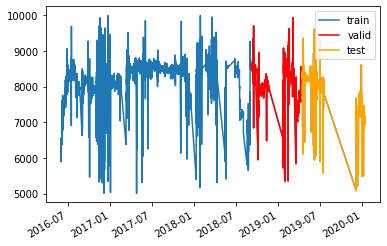

In [7]:
t1 = df.iloc[[sp1]].index[0]
t2 = df.iloc[[sp2]].index[0]
df['0997_real'].plot(label='train')
df['0997_real'][(df.index > t1)&(df.index < t2)].plot(color = 'red',label='valid')
df['0997_real'][(df.index > t2)].plot(color = 'orange',label='test')
plt.legend()
plt.show()

# MinMaxScaler

In [8]:
from sklearn.preprocessing import MinMaxScaler

mm_x = MinMaxScaler().fit(X)
mm_y = MinMaxScaler().fit(Y)

X_train = mm_x.transform(X_train)
X_valid = mm_x.transform(X_valid)
X_test = mm_x.transform(X_test)

Y_train = mm_y.transform(Y_train)
Y_valid = mm_y.transform(Y_valid)
Y_test = mm_y.transform(Y_test)

joblib.dump(mm_x,'./model/mm_x.pkl')
joblib.dump(mm_y,'./model/mm_y.pkl')
print('save done!')

save done!


# convert to torch tensor

In [9]:
import torch

X_train = torch.tensor(X_train).cuda()
X_test = torch.tensor(X_test).cuda()

X_valid = torch.tensor(X_valid).cuda()
Y_valid = torch.tensor(Y_valid).cuda()

Y_train = torch.tensor(Y_train).cuda()
Y_test = torch.tensor(Y_test).cuda()

print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train.shape,Y_valid.shape,Y_test.shape)

torch.Size([84638, 507]) torch.Size([18137, 507]) torch.Size([18137, 507])
torch.Size([84638, 1]) torch.Size([18137, 1]) torch.Size([18137, 1])


# create data_iter

In [10]:
train = torch.utils.data.TensorDataset(X_train, Y_train)
valid = torch.utils.data.TensorDataset(X_valid, Y_valid)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)

# Construct the neural network

In [11]:
class panet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(time_step,1)
        self.block_1 = nn.Sequential(nn.Linear(1,128),nn.ReLU(),nn.Linear(128,1))
        self.conv_1 = nn.Conv1d(in_channels = num_sensor-1,
                                out_channels = 1, 
                                kernel_size = 1,
                                padding = 0)
        
        self.pool = nn.MaxPool1d(kernel_size = 1)
        
        self.block_2 = nn.Sequential(nn.Linear(39,128),nn.ReLU(),nn.Linear(128,1))
        
    def forward(self,x):
        feed,factor = self.fetch(x)
        
        z1 = self.linear_1(feed)
        
        z2 = self.block_1(z1)
        
        z3 = self.pool(F.relu(self.conv_1(factor)))
        z3 = z3.view(-1,z3.shape[1]*z3.shape[2])
        z3 = self.block_2(z3)
        
        return F.sigmoid(z1+z2+z3)
        
    def fetch(self,x):
        x_resize = x.view(-1,time_step,num_sensor)
        feed = x_resize[:,:,0]
        
        # batch,time,sensor -> batch,sensor,time 
        factor = x_resize[:,:,1:].permute(0,2,1) 
        
        return feed,factor

In [12]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0)
        except:
            pass

In [13]:
net = panet().cuda().double()
net.apply(init_weights)

panet(
  (linear_1): Linear(in_features=39, out_features=1, bias=True)
  (block_1): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv_1): Conv1d(12, 1, kernel_size=(1,), stride=(1,))
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (block_2): Sequential(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [14]:
X_test.shape

torch.Size([18137, 507])

In [15]:
net(X_test)

tensor([[0.7381],
        [0.7382],
        [0.7381],
        ...,
        [0.6500],
        [0.6453],
        [0.6430]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

# tensorboard

In [16]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (X_test,))

# torchviz

In [17]:
#torchviz.make_dot(net(X_test).mean(),params=dict(net.named_parameters()))

# loss_function and optimizer

In [18]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
loss_function = nn.MSELoss()

# Training and evaluation

In [19]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            i += 1
        
        # eval model
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for x, y in valid_iter:
                loss = loss_function(net(x),y)
                val_loss += loss.item()
                j += 1
        
        # caculate avg loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            joblib.dump(net,'./model/net.pkl')
            print('model saved')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    print('model save at ./model/net.pkl')

model saved
epochs 0 train_avg_loss 0.0053 valid_avg_loss 0.0042
model saved
epochs 1 train_avg_loss 0.0029 valid_avg_loss 0.0019
model saved
epochs 2 train_avg_loss 0.0014 valid_avg_loss 0.0011
model saved
epochs 3 train_avg_loss 0.0010 valid_avg_loss 0.0009
model saved
epochs 4 train_avg_loss 0.0010 valid_avg_loss 0.0009
epochs 5 train_avg_loss 0.0010 valid_avg_loss 0.0009
epochs 6 train_avg_loss 0.0010 valid_avg_loss 0.0009
epochs 7 train_avg_loss 0.0010 valid_avg_loss 0.0009
epochs 8 train_avg_loss 0.0009 valid_avg_loss 0.0009
epochs 9 train_avg_loss 0.0009 valid_avg_loss 0.0009
epochs 10 train_avg_loss 0.0009 valid_avg_loss 0.0010
epochs 11 train_avg_loss 0.0009 valid_avg_loss 0.0010
epochs 12 train_avg_loss 0.0009 valid_avg_loss 0.0010
epochs 13 train_avg_loss 0.0009 valid_avg_loss 0.0010
epochs 14 train_avg_loss 0.0009 valid_avg_loss 0.0009
epochs 15 train_avg_loss 0.0009 valid_avg_loss 0.0009
epochs 16 train_avg_loss 0.0009 valid_avg_loss 0.0009
epochs 17 train_avg_loss 0.0009 

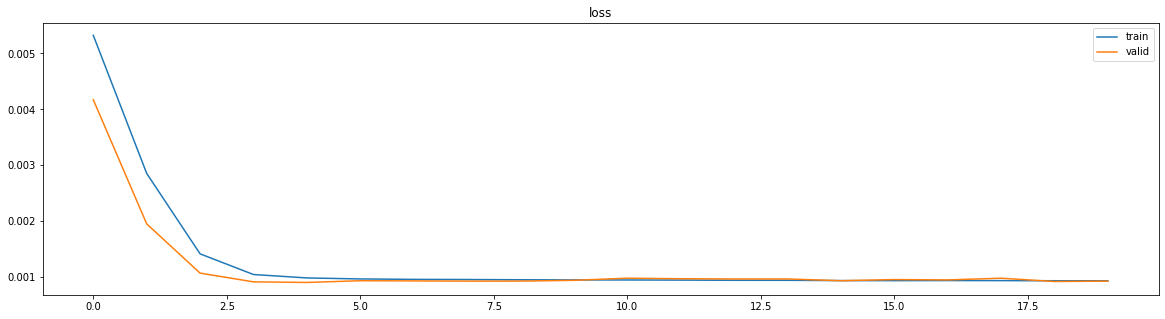

model save at ./model/net.pkl
34.58915448188782


In [20]:
s = time.time()
train(net,train_iter,loss_function,optimizer,num_epochs=20)
print(time.time()-s)

# load best net

In [21]:
net = joblib.load('./model/net.pkl')
net = net.eval()
net

panet(
  (linear_1): Linear(in_features=39, out_features=1, bias=True)
  (block_1): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv_1): Conv1d(12, 1, kernel_size=(1,), stride=(1,))
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (block_2): Sequential(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

# metrics

In [22]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100


feed = X.values.reshape(-1,time_step,num_sensor).mean(axis=1)
feed = pd.DataFrame(feed,columns=x_col,index=idx)
feed = feed['MLPAP_FQ-0619.PV']

def show_result(X,Y,index,tag):
    t = pd.DataFrame(index=index)
    t['0619'] = feed[index]
    t['0997_real'] = mm_y.inverse_transform(Y.detach().cpu().numpy().reshape(-1,1)).ravel()
    t['0997_pred'] = mm_y.inverse_transform(net(X).detach().cpu().numpy().reshape(-1,1)).ravel()
    t['單耗_real'] = t['0619']/t['0997_real']
    t['單耗_pred'] = t['0619']/t['0997_pred']
    t['0997_R2'] = r2_score(t['0997_real'],t['0997_pred'])
    t['0997_MAPE'] = mape(t['0997_real'],t['0997_pred'])
    t['單耗RMSE'] = sqrt(mean_squared_error(t['單耗_real'],t['單耗_pred']))
    t['單耗MAPE'] = mape(t['單耗_real'],t['單耗_pred'])
    m = t.iloc[[0],-2:]
    m.index = [tag]
    t = t.iloc[:,:-2]
    return t,m

# make prediction(train)

In [23]:
t1,m1 = show_result(X_train,Y_train,idx[:sp1],'train')
m1.head()

,單耗RMSE,單耗MAPE
train,0.018906,1.165733


In [24]:
t1.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE
2016-06-01 02:40:00,5694.148613,6467.7600,6400.453475,0.880390,0.889648,0.902327,1.173461
2016-06-01 02:50:00,5694.210400,6450.8740,6411.103606,0.882704,0.888179,0.902327,1.173461
2016-06-01 03:00:00,5693.874564,6443.6900,6388.449922,0.883636,0.891276,0.902327,1.173461
2016-06-01 03:10:00,5694.258010,6430.3833,6398.419452,0.885524,0.889948,0.902327,1.173461
2016-06-01 03:20:00,5694.593251,6446.3940,6398.552884,0.883377,0.889981,0.902327,1.173461


# make prediction(valid)

In [25]:
t2,m2 = show_result(X_valid,Y_valid,idx[sp1:sp2],'valid')
m2.head()

,單耗RMSE,單耗MAPE
valid,0.018359,1.170615


In [26]:
t2.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE
2018-09-07 13:00:00,7726.111903,8574.377,8503.219892,0.901070,0.908610,0.895954,1.173678
2018-09-07 13:10:00,7726.742331,8558.691,8509.596261,0.902795,0.908003,0.895954,1.173678
2018-09-07 13:20:00,7727.409244,8552.359,8516.022592,0.903541,0.907397,0.895954,1.173678
2018-09-07 13:30:00,7727.952138,8558.983,8480.137871,0.902905,0.911300,0.895954,1.173678
2018-09-07 13:40:00,7728.790531,8559.570,8497.845605,0.902941,0.909500,0.895954,1.173678


# make prediction(test)

In [27]:
t3,m3 = show_result(X_test,Y_test,idx[sp2:],'test')
m3.head()

,單耗RMSE,單耗MAPE
test,0.028169,1.816477


In [28]:
t3.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE
2019-04-15 19:00:00,7483.497254,8226.883,8133.793412,0.909639,0.920050,0.847492,1.878737
2019-04-15 19:10:00,7483.339126,8249.652,8211.716283,0.907110,0.911300,0.847492,1.878737
2019-04-15 19:20:00,7482.915685,8266.681,8159.800615,0.905190,0.917046,0.847492,1.878737
2019-04-15 19:30:00,7482.441633,8281.450,8171.541691,0.903518,0.915671,0.847492,1.878737
2019-04-15 19:40:00,7482.044923,8263.153,8122.289780,0.905471,0.921174,0.847492,1.878737


In [29]:
pred_0997_all = t1.append(t2).append(t3)['0997_pred']
pred_0997_all.head()

2016-06-01 02:40:00    6400.453475
2016-06-01 02:50:00    6411.103606
2016-06-01 03:00:00    6388.449922
2016-06-01 03:10:00    6398.419452
2016-06-01 03:20:00    6398.552884
Name: 0997_pred, dtype: float64

In [30]:
pred_0997_all.to_csv('./data/pred_0997_all.csv')
print('save done')

save done


# check net

In [31]:
net.linear_1.weight.data

tensor([[ 0.0892, -0.0482, -0.3012, -0.2736, -0.1576,  0.2832,  0.2858, -0.0735,
          0.2176,  0.3120, -0.2344,  0.2927, -0.3572,  0.2719,  0.0878, -0.2083,
          0.0847,  0.1194, -0.1365,  0.2250, -0.3013,  0.0709,  0.0700,  0.1319,
          0.1151, -0.1560, -0.1563,  0.1144, -0.1346,  0.2668,  0.1152,  0.0634,
          0.2856, -0.3364,  0.2832,  0.2913,  0.2962, -0.0448, -0.0564]],
       device='cuda:0', dtype=torch.float64)

In [32]:
net.linear_1.weight.data.argmax()

tensor(9, device='cuda:0')